In [2]:
from typing import List, Any, Dict

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

In [3]:
class TreeId3Classifier:
    def __init__(self):
        self.tree = None

    def fit(self, input: pd.DataFrame, output: pd.Series) -> None:
        data = input.copy()
        data[output.name] = output
        self.tree = self.decision_tree(data, input, input.columns, output.name)

    def predict(self, input: pd.DataFrame) -> List[float]:
        # convert input data into a dictionary of samples
        samples = input.to_dict(orient='records')
        predictions = []

        # make a prediction for every sample
        for sample in samples:
            predictions.append(self.make_prediction(sample, self.tree, 1.0))

        return predictions

    def calculate_entropy(self, attribute_column: pd.Series) -> float:
        # find unique values and their frequency counts for the given attribute
        values, counts = np.unique(attribute_column, return_counts=True)
        length = len(attribute_column)
        return sum([-(counts[i] / length) * np.log2(counts[i] / length) for i in range(len(values))])

    def information_gain(self, data: pd.DataFrame, feature_attribute_name: str, target_attribute_name: str) -> float:
        # find total entropy of given subset
        total_entropy = self.calculate_entropy(data[target_attribute_name])

        # find unique values and their frequency counts for the attribute to be split
        values, counts = np.unique(data[feature_attribute_name], return_counts=True)

        total_weighted_entropy = 0

        for i in range(len(values)):
            subset_probability = counts[i] / len(data)
            subset_entropy = self.calculate_entropy(data[data[feature_attribute_name] == values[i]][target_attribute_name])
            total_weighted_entropy += subset_probability * subset_entropy

        # calculate information gain
        return total_entropy - total_weighted_entropy

    def decision_tree(self, data: pd.DataFrame, original_data: pd.DataFrame, feature_attribute_names: List[str],
                      target_attribute_name: str, parent_node_class=None) -> Dict[str, Any]:
        # base cases:
        # if data is pure, return the majority class of subset
        unique_classes = np.unique(data[target_attribute_name])
        if len(unique_classes) <= 1:
            return unique_classes[0]
        # if subset is empty, ie. no samples, return majority class of original data
        if len(data) == 0:
            values, counts = np.unique(data[target_attribute_name], return_counts=True)
            majority_class_index = np.argmax(counts)
            parent_node_class = values[majority_class_index]
            return values[majority_class_index]
        # if data set contains no features to train with, return parent node class
        if len(feature_attribute_names) == 0:
            return parent_node_class
        # if none of the above are true, construct a branch:

        # determine parent node class of current branch
        values, counts = np.unique(data[target_attribute_name], return_counts=True)
        majority_class_index = np.argmax(counts)
        parent_node_class = values[majority_class_index]

        # determine information gain values for each feature
        # choose feature which best splits the data, ie. highest value
        ig_values = [self.information_gain(data, feature, target_attribute_name) for feature in
                     feature_attribute_names]
        best_feature_index = np.argmax(ig_values)
        best_feature = feature_attribute_names[best_feature_index]

        # create tree structure, empty at first
        tree = {best_feature: {}}

        # remove best feature from available features, it will become the parent node
        feature_attribute_names = [feature for feature in feature_attribute_names if feature != best_feature]

        # create nodes under parent node
        parent_attribute_values = np.unique(data[best_feature])
        for value in parent_attribute_values:
            sub_data = data[data[best_feature] == value]

            # call the algorithm recursively
            subtree = self.decision_tree(sub_data, original_data, feature_attribute_names, target_attribute_name,
                                         parent_node_class)

            # add subtree to original tree
            tree[best_feature][value] = subtree

        return tree

    def make_prediction(self, sample: Dict[str, Any], tree: Dict[str, Any], default: float = 1.0) -> float:
        # map sample data to tree
        for attribute in sample.keys():
            # check if feature exists in tree
            if attribute in tree.keys():
                try:
                    result = tree[attribute][sample[attribute]]
                except:
                    return default

                result = tree[attribute][sample[attribute]]

                # if more attributes exist within result, recursively find best result
                if isinstance(result, dict):
                    return self.make_prediction(sample, result)
                else:
                    return result

In [9]:
df = pd.read_csv('C:/Users/Milance/Desktop/lenses_data.csv', index_col='index')
X = df.drop(columns="y")
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = TreeId3Classifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

score1 = accuracy_score(y_test, y_pred)
print(score)

0.6666666666666666


In [5]:
score1

1.0

In [10]:
model.tree

{'tear_rate': {1: 3,
  2: {'astigmatic': {1: {'age': {1: 2,
      2: 2,
      3: {'spectacle_prescription': {1: 3, 2: 2}}}},
    2: {'age': {1: 1, 2: {'spectacle_prescription': {1: 1, 2: 3}}, 3: 1}}}}}}

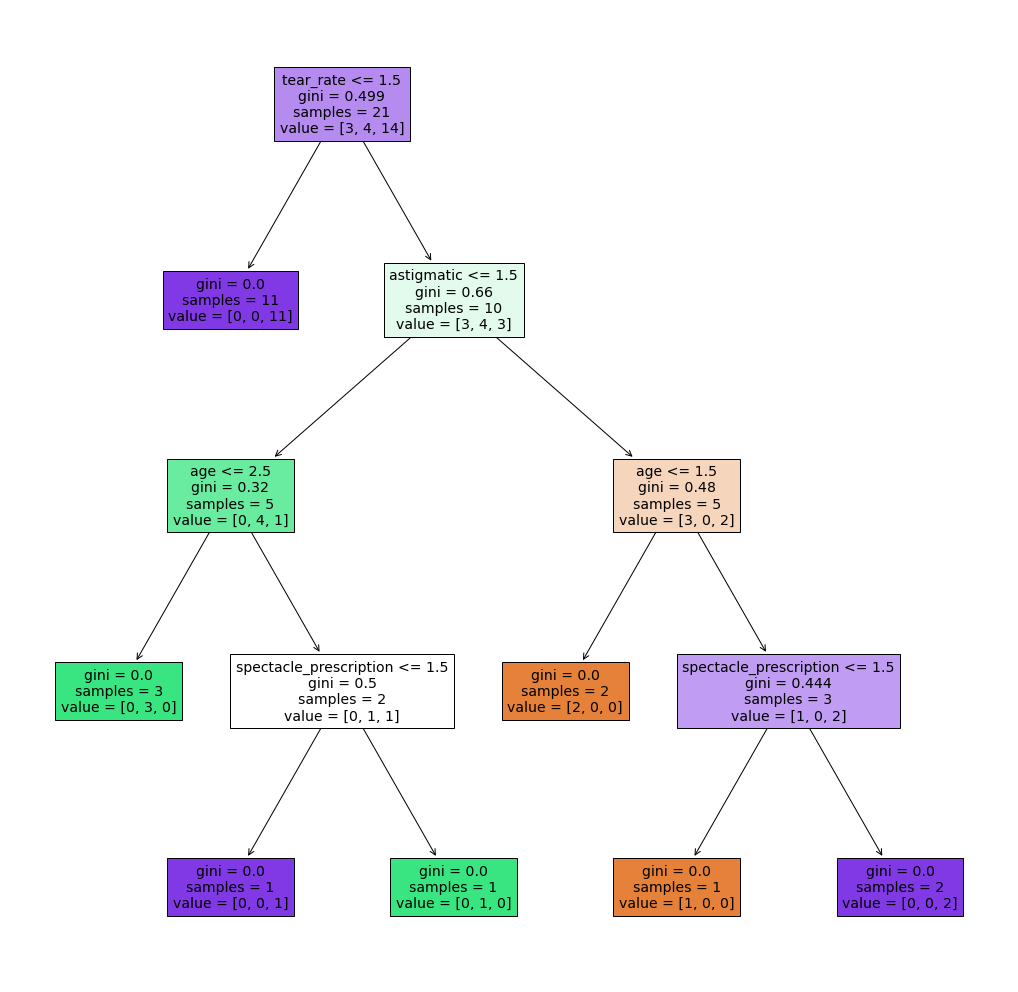

In [7]:
fig = plt.figure(figsize=(18,18))
ax = plt.subplot(111)
tree.plot_tree(decision_tree,feature_names=X_train.columns, ax=ax, filled=True)
print()